# Spam filtering using Naive Bayes

This small notebook was made following the [Bootstrap-ML](http://sergioagostinho.com/bootstrap-ml) workshop which took place on the 22nd of March 2018 at the Mathematics Department of [Instituto Superior Técnico](https://tecnico.ulisboa.pt/en/).

This workshop, given by [Sérgio Agostinho](https://www.linkedin.com/in/sergioagostinho), was a two-hour introductory session in Machine Learning (ML). At the end of the session, the participants were encouraged to implement one of the ML algorithms we explored, the Naive Bayes algorithm, for a simple application of spam filtering.

The materials of the workshop, including the notebook from which this one was inspired, can be found at [Sérgio's GitHub repository](https://github.com/SergioRAgostinho/bootstrap-ml).

For this notebook, the required packages are `numpy`, `matplotlib`, `seaborn` and `sklearn`.

## Read the data

The dataset we are going to use, which can be found in this [page](http://csmining.org/index.php/ling-spam-datasets.html), was used in the paper:

> I. Androutsopoulos, J. Koutsias, K.V. Chandrinos, George Paliouras, and C.D. Spyropoulos, "An Evaluation of Naive Bayesian Anti-Spam Filtering". In Potamias, G., Moustakis, V. and van Someren, M. (Eds.), Proceedings of the Workshop on Machine Learning in the New Information Age, 11th European Conference on Machine Learning (ECML 2000), Barcelona, Spain, pp. 9-17, 2000.

The arXiv version may be found [here](https://arxiv.org/abs/cs/0006013).

The data we are going to use here was already preprocessed, so that the focus of this notebook is in the algorithm implementation. In particular, stop words such as 'and' and 'but' were removed and words like 'walk', 'walks' and 'walking' were merged into 'walk'.

First, we read the data, which is in a single file in uncompressed .npz format.

In [1]:
import numpy as np

data = np.load('data/lingspam/lingspam.npz')

There are 4 files inside:

In [2]:
data.files

['words', 'file_names', 'targets', 'target_names']

The 'words' file contains all the relevants words on each email, as a list of list of words. Note that all words with less than 3 letters were previously filtered out and all numbers were replaced by a '#' sign.

In [3]:
data['words'][0][:15]

['sposs',
 'sound',
 'pattern',
 'spontaneous',
 'speech',
 'production',
 'perception',
 'aix',
 'provence',
 'france',
 'september',
 '#',
 'european',
 'speech',
 'communication']

The 'file_names' file contains a list of strings with the names of the files.

In [4]:
data['file_names'][0]

'9-157msg1.txt'

The 'targets' file contains a list of Booleans which indicates if an email is spam or not.

In [5]:
data['targets'][0]

False

The 'target_names' contains the names of the two classes, 'spam' or 'ham' (not spam).

In [6]:
data['target_names']

array(['ham', 'spam'], dtype='<U4')

## Create the features

Let's see how many emails we have in our dataset.

In [7]:
num_emails = len(data['words'])
print(num_emails)

2893


Each of the emails has repeated words. Let's create a dictionary which stores the number of occurences of each word for all emails.

In [8]:
from collections import Counter, OrderedDict

# create a dictionary with each word as the key and the number of occurences as the value
cnt = Counter()
total_words = 0
for entry in data['words']:
    total_words += len(entry)    # total number of words in the dataset
    for word in entry:
        cnt[word] += 1

# order the previous dictionary by most common words
ordered_cnt = OrderedDict(cnt.most_common())

The total number of unique words is:

In [9]:
len(cnt)

49932

while the total number of words is:

In [10]:
total_words

779547

That's quite a lot of unique words for 2893 emails! Let's check which words are the most common using a plot.

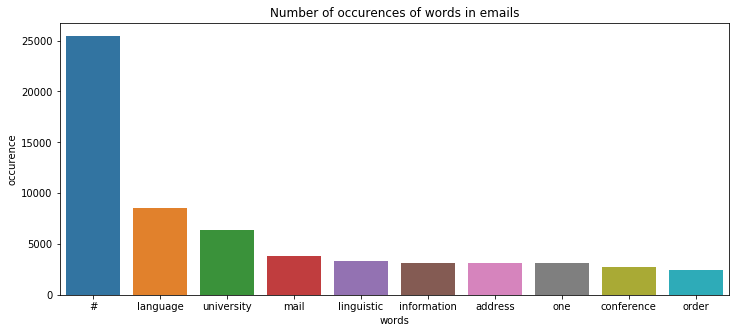

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# create plot
plt.figure(figsize=(12,5))
sns.barplot(x=list(ordered_cnt.keys())[0:10], y=list(ordered_cnt.values())[0:10])
_ = plt.xlabel("words")
_ = plt.ylabel("occurence")
_ = plt.title("Number of occurences of words in emails")

# save figure
plt.savefig('plot.png', dpi=200)

We see that numbers of all kinds are by far the most common words, followed by 'language' and 'university'.

One way to significantly reduce the number of unique words to consider is to pick those unique words which capture, say, 90% of the total words occurences.

In [12]:
# number of unique words capturing 90% of the total words occurences
threshold = 0.9 * total_words   # 90% of all words
amount = 0
num_words_threshold = 0
for word, occurence in ordered_cnt.items():
    if amount < threshold:
        amount += occurence
        num_words_threshold += 1
    else:
        break

The number of unique words capturing 90% of the total words occurrences is then:

In [13]:
num_words_threshold

9451

Let's save these 9451 words into a new list.

In [14]:
unique_words_90 = list(OrderedDict(cnt.most_common(num_words_threshold)).keys())

Now we define a function which receives the list of words from the emails, gets the words which are in the `unique_words_90` list, with their number of occurences, and then creates a feature array with the number of occurences in the same order as they appear in the  `unique_words_90` list.

In [15]:
def create_feature(list):
    
    # list with words from list which are in the unique_words_90 list
    words_in_unique_list = [word for word in list if word in unique_words_90]
    
    # dictionary created from previous list counting the number of occurences
    words_in_unique_dict = Counter(words_in_unique_list)
    
    # array of zeros, with the same number of elements as the unique_words_90 list
    features = np.zeros(len(unique_words_90), dtype=np.uint32)
    
    # for each word:occurence in dictionary, save occurence in the correct slot of features
    for word, occurence in words_in_unique_dict.items():
        features[unique_words_90.index(word)] = occurence
    
    return features

To check what this function does with the first email, for example:

In [16]:
print(create_feature(data['words'][0]))

[12  5  0 ...  0  0  0]


This means that the first e-mail has '#' 12 times, 'language' 5 times, etc. It seems that everything is working as expected.

To finalize, we need to create the **features matrix** (to be used in the algorithm): each element of this list of lists corresponds to one email and it is obtained used the function `create_feature` above.

In [17]:
# creates a matrix of zeros with dimensions of (number of targets)x(number of unique words)
X = np.empty((len(data['targets']), len(unique_words_90)), dtype=np.uint32)

# use function create_feature for each row
for i, email in enumerate(data['words']):
    X[i,:] = create_feature(email)

The features matrix looks like this:

In [18]:
X

array([[12,  5,  0, ...,  0,  0,  0],
       [11,  0,  2, ...,  0,  0,  0],
       [20,  1, 30, ...,  0,  0,  0],
       ...,
       [10,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)

The target vector is just:

In [19]:
y = data['targets']

## Split the dataset

Before applying the algorithm, we split the dataset into a **training set** and a **test set**, in a 70:30 proportion. This can be done using the `train_test_split` function of `sklearn`.

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (2025, 9451)
X_test:  (868, 9451)
y_train:  (2025,)
y_test:  (868,)


## Implement Naive Bayes algorithm with scikit-learn

The machine learning algorithm we are going to use here is the **Naive Bayes Classifier**. For the mathematical details, check this ***blog post*** I wrote for this implementation. For the implementation using `scikit-learn`, check the [documentation](http://scikit-learn.org/stable/modules/naive_bayes.html).

Here, we are going to use `MultinomialNB`, which implements the Naive Bayes algorithm for multinomially distributed data. First, we use the training set to fit the model.

In [21]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Then, we predict the output using the test set and compute the **confusion matrix** to evaluate the performance of the algorithm.

In [22]:
from sklearn.metrics import confusion_matrix

prediction = nb.predict(X_test)

print(confusion_matrix(y_test, prediction))

[[739   7]
 [  2 120]]


From the confusion matrix, we see that the Naive Bayes classifier got the following results:
* Out of the 728 actual instances of 'ham' (not spam), it predicted correctly 726 of them;
* Out of the 140 actual instances of spam, it predicted correctly 138 of them.